In [1]:
"""
VirDetect-AI: API for identifying partial virus protein sequences in metagenomic data

Author Code: Alida Zárate
Contact: alida.zarate@ibt.unam.mx
GitHub Repository: https://github.com/alyzart22/VirDetect-AI
Published on: [Pending]
Description:
This notebook contains a Deep Learning model VirDetect-AI for identifying partial virus protein sequences in metagenomic data

License: [OA]
"""

'\nVirDetect-AI: API for identifying partial virus protein sequences in metagenomic data\n\nAuthor Code: Alida Zárate\nContact: alida.zarate@ibt.unam.mx\nGitHub Repository: https://github.com/alyzart22/VirDetect-AI\nPublished on: [Pending]\nDescription:\nThis notebook contains a Deep Learning model VirDetect-AI for identifying partial virus protein sequences in metagenomic data\n\nLicense: [OA]\n'

# **VirDetect-AI**
This notebook contains a Deep Learning model for identifying partial virus protein sequences in metagenomic data.



[GitHub Repository](https://github.com/alyzart22/VirDetect-AI)

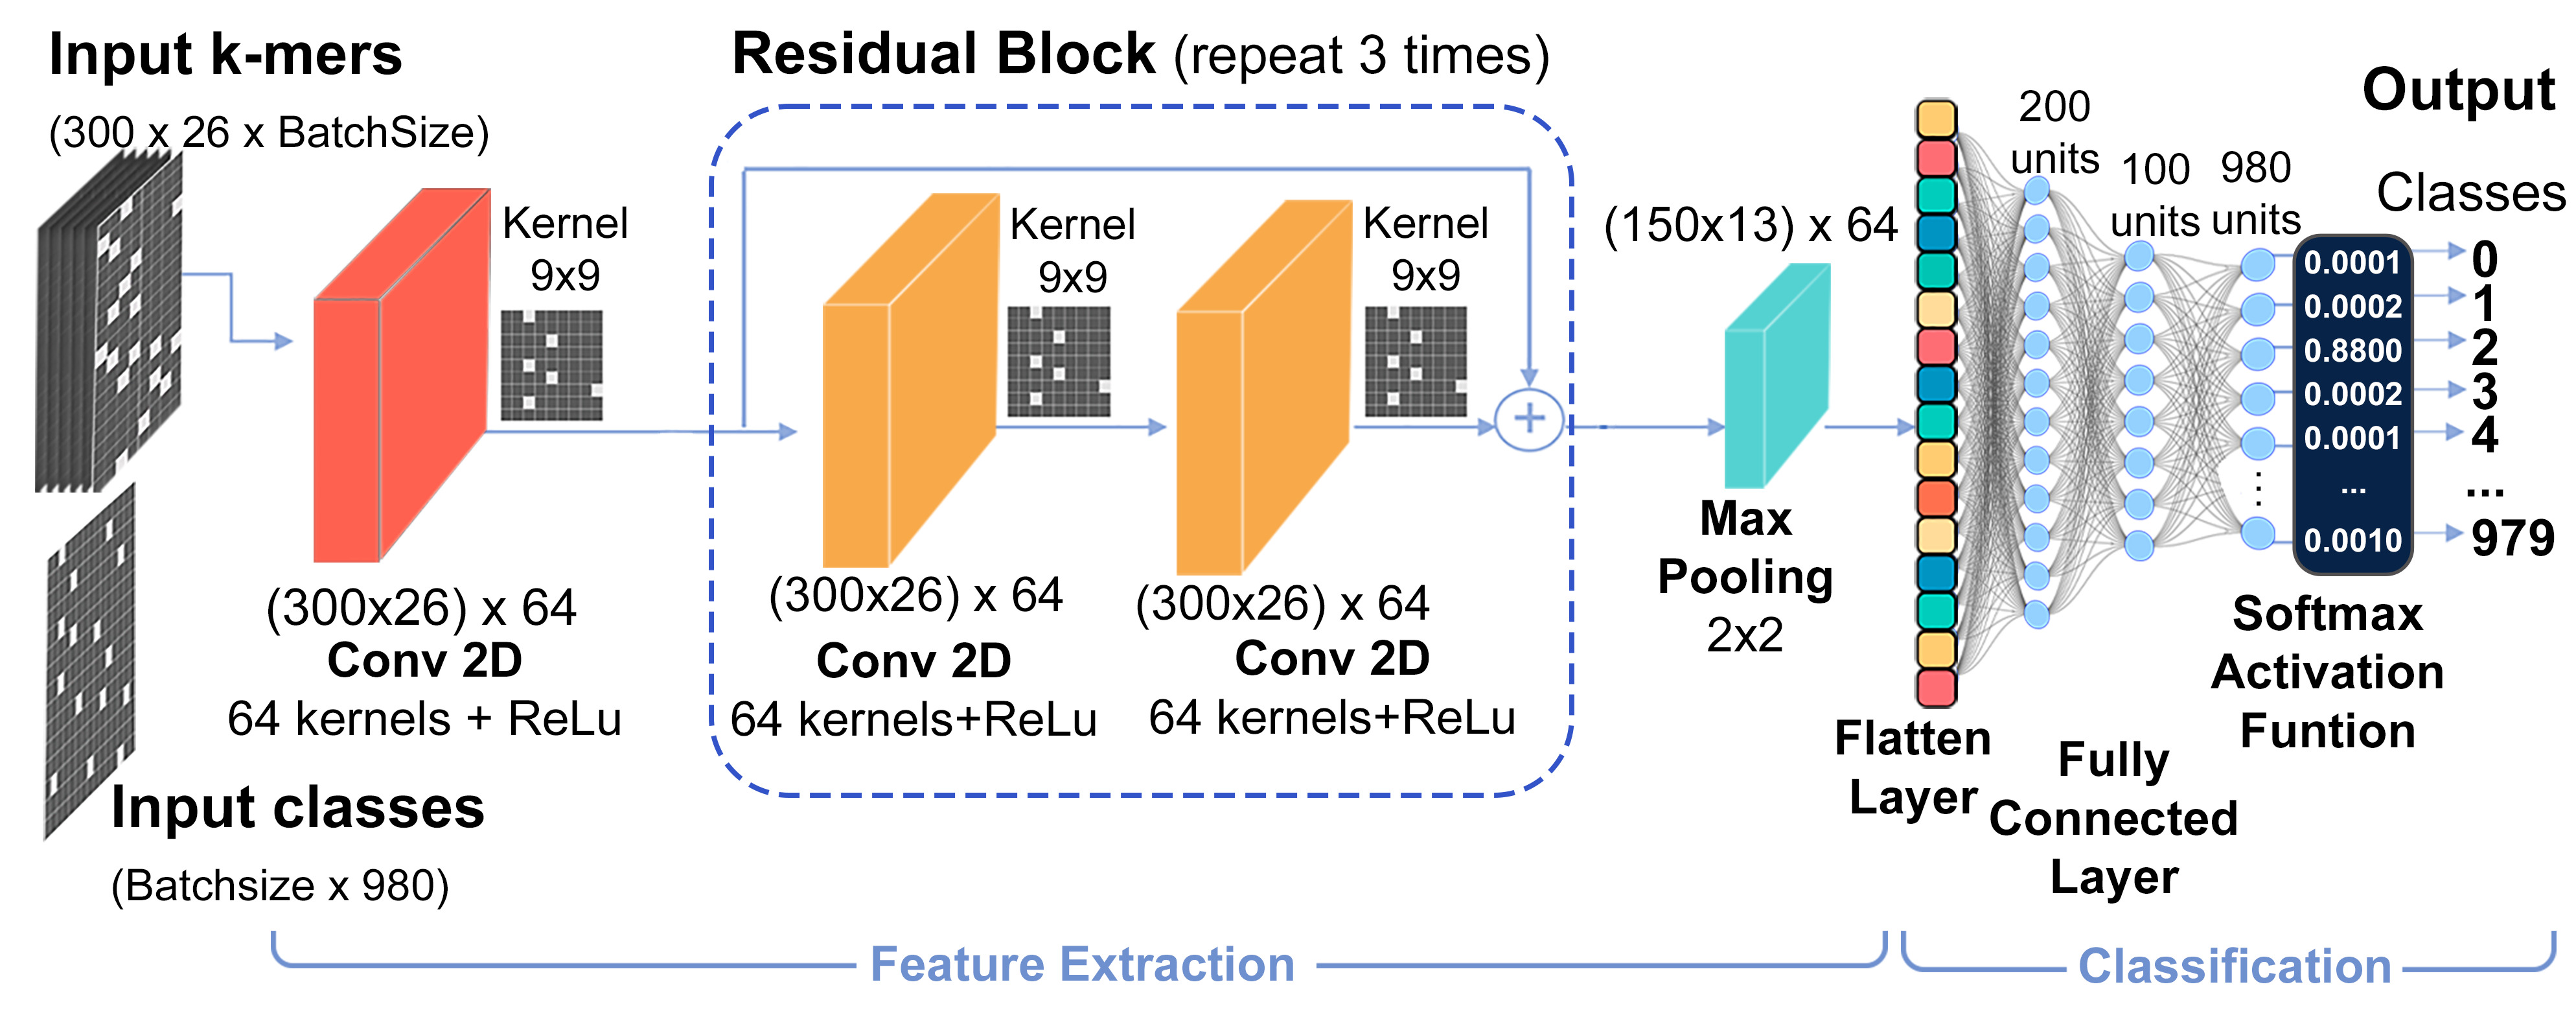


# Input Files:
## **User:** Fasta Files (amino acids)
### The **Mode** parameter can be modified in the section **Modify parameters**

Mode: 0 (default) allows input sequences >= 300 aa length

Mode: 1 Input sequences > 255 aa length



##**System**:The model VirDetect-AI and reference file classes are downloaded automatically


# Outputs:
Report by kmers, Report final and plots are generated and saved in the **outputs** folder, which is a temporary folder in google drive [content], remember to download your results.

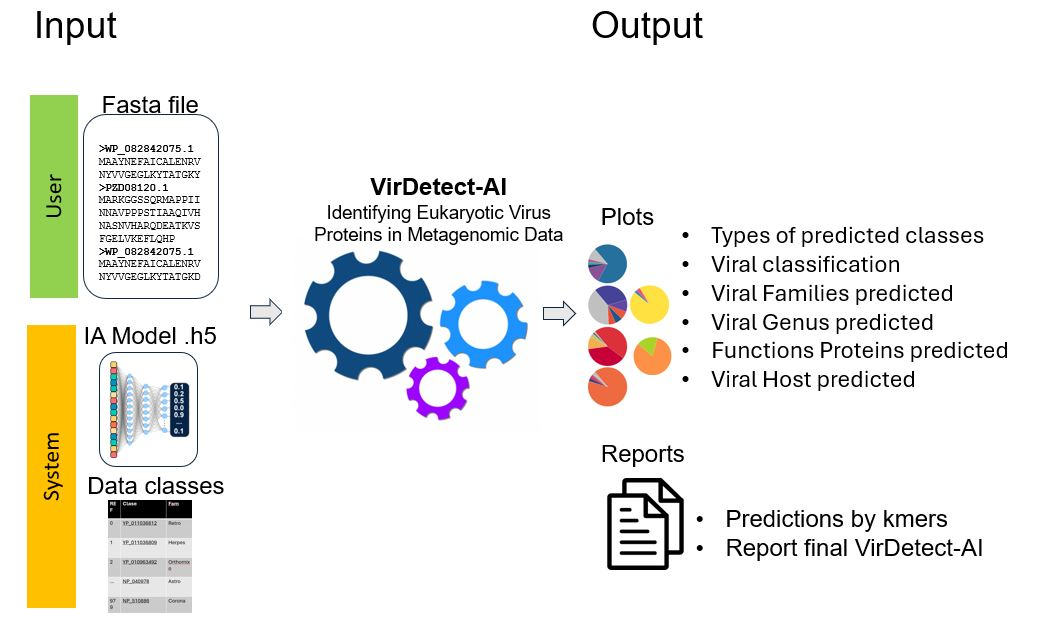

## Install Dependences externals


In [2]:
!pip install biopython==1.81


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.4 MB/s eta 0:00:00


## Import libraries

In [3]:
import os
import sys
from Bio.Seq import Seq
from Bio import SeqIO
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import tensorflow as tf #agrege yo
from datetime import datetime
import time
import math
import time
from tqdm import tqdm
import random
from google.colab import files

## Verify Existing GPU
### In the upper right corner you can choose the type of runtime environment

*   Make sure you are connected to a gpu card.
*   If for some reason you cannot connect to a gpu card, this program also works with TPU with the disadvantage of being slower.



In [4]:
print("VirDetect-AI Initialization Processes...........................")

print("Detecting GPUs  ..................................................")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

VirDetect-AI Initialization Processes...........................
Detecting GPUs  ..................................................
1 Physical GPUs, 1 Logical GPUs


## Allows access to Google Drive


In [5]:
##Allows acceses to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload your own fasta file

In [11]:
uploaded = files.upload()
for path_fasta in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=path_fasta, length=len(uploaded[path_fasta])))

Saving birnaviridae.fasta to birnaviridae.fasta
User uploaded file "birnaviridae.fasta" with length 4525 bytes


## Download the model VirDetect-AI and classes reference file

In [7]:
import gdown
import requests
import os

# Download the model file from Google Drive
url_modelo = "https://drive.google.com/uc?id=1jVLshzOz3bOPWuIbaoNSAV4yRl4JBAOD"
path_modelo = "/content/model_euk30_300_20_980_9x9_f64_bs128.h5"
gdown.download(url_modelo, path_modelo, quiet=False)

# Download the classes reference file from Github
url_referencia = "https://raw.githubusercontent.com/alyzart22/VirDetect-AI/main/Notebook_VirDetect-AI/ref_api_300_20_980.csv"
path_referencia = "/content/ref_api_300_20_980.csv"
response = requests.get(url_referencia)
with open(path_referencia, 'wb') as f:
    f.write(response.content)

# Create output path
path_create = "/content/outputs/"
os.makedirs(path_create, exist_ok=True)

# Print paths
print(f"The model VirDetect-AI was downloaded in: {path_modelo}")
print(f"The classes reference file was downloaded in : {path_referencia}")
print(f"Output path : {path_create}")

Downloading...
From (original): https://drive.google.com/uc?id=1jVLshzOz3bOPWuIbaoNSAV4yRl4JBAOD
From (redirected): https://drive.google.com/uc?id=1jVLshzOz3bOPWuIbaoNSAV4yRl4JBAOD&confirm=t&uuid=80e560ac-b119-4df3-ac7f-e96c9ac14c6b
To: /content/model_euk30_300_20_980_9x9_f64_bs128.h5
100%|██████████| 325M/325M [00:01<00:00, 193MB/s]


The model VirDetect-AI was downloaded in: /content/model_euk30_300_20_980_9x9_f64_bs128.h5
The classes reference file was downloaded in : /content/ref_api_300_20_980.csv
Output path : /content/outputs/


## Modify parameters
This model allows modify the following parameters:

**mode=0**, Default, this mode allows sequences >= 300 aa lenght

**mode=1**, This mode allows sequences > 255 aa lenght, fill aa to procces only kmers of 300aa, this mode can analyzes more sequences.

**Note important:** It is highly discouraged to modify any other parameters in the code box below.






In [12]:
mode=0

In [13]:

#-----------------Parameters importants-------------------
partes_name = path_fasta.split(".")
tipo = partes_name[0]
kmer_long= int(300) #100 300 500
kmer_stride= int(20) #20 40 60
clase_negativa_pro=int(978) # 2225 978 509
clase_negativa_variada=int(979) #2226 979 510
mode = int(mode) # 0 = allows input sequences >= 300 aa length , # 1 = allows input sequences > 255 aa length
fecha= datetime.now()
fecha_=str(fecha.hour)+'-'+str(fecha.minute)+'-'+str(fecha.second)+'_'+str(fecha.day)+'-'+str(fecha.month)+'-'+str(fecha.year)
os.makedirs(path_create+tipo+str(fecha.hour)+'-'+str(fecha.minute)+'-'+str(fecha.second)+'_'+str(fecha.day)+'-'+str(fecha.month)+'-'+str(fecha.year))
path=path_create+tipo+str(fecha.hour)+'-'+str(fecha.minute)+'-'+str(fecha.second)+'_'+str(fecha.day)+'-'+str(fecha.month)+'-'+str(fecha.year)+"/"
#Time start defined


## Clasification

In [14]:
def secuencias_detalle(secuencias, kmer_long, mode):
    print(":::::::::::::: Fasta Sequences Details :::::::::::::::::::::::::::::::::::::")
    ids=[]
    registros=[]
    tamanos=[]
    condador_no_300aa=0
    if mode == 0:
        print("::::::::::::::: Mode_0: Do not fill kmers length, input kmers lenght allowed: >", kmer_long,"aa ::::" )
        for i in secuencias:
            if (len(i.seq)) > kmer_long-1:
                ids.append(i.description)
                #ids.append(i.id)
                registros.append(i.seq)
                tamanos.append(len(i.seq))
            else:
                condador_no_300aa=condador_no_300aa+1
        print("Total of sequences:", condador_no_300aa+len(tamanos))
        print("Total of sequences > a", str(kmer_long) ,"aa:",len(tamanos),"<-- This sequences will be introduced to IA model ")

    if mode == 1:
        kmers_allowed= int(kmer_long-(kmer_long*.15))
        print("::::::::::::::: Mode_1: fill kmers length, input kmers lenght allowed: >", kmers_allowed,"aa ::::" )
        for i in secuencias:
            if (len(i.seq)) > kmers_allowed -1 and (len(i.seq)) < kmer_long :
                len_substring=kmer_long-len(i.seq)
                sub_string_x='X'* (len_substring+1)
                ids.append(i.id)
                seq_filled=i.seq+sub_string_x
                #print("f:",seq_filled)
                registros.append(seq_filled)
                tamanos.append(len(i.seq))
            elif (len(i.seq)) > kmer_long-1:
                ids.append(i.id)
                #print("N:",i.seq)
                registros.append(i.seq)
                tamanos.append(len(i.seq))
            else:
                condador_no_300aa=condador_no_300aa+1

        print("Total of sequences:", condador_no_300aa+len(tamanos))
        print("Total of sequences > a", str(kmers_allowed) ,"aa:",len(tamanos),"<-- This sequences will be introduced to IA model ")
    if len(tamanos) == 0:
      print("¡Exit Alert!")
      print("All contigs are less than 300 amino acids. This Program works for contigs greater than 299 amino acids.")
      print("The Tool VirDetect-AI has concluded its execution")
      sys.exit()  # Salir del programa

    mean_len=round(sum(tamanos)/len(tamanos), 2)
    st_dev_len= round(np.std(tamanos),2)
    print("Major lenght aa :", max(tamanos))
    print("Minor lenght aa:", min(tamanos))
    print("Mean lenght aa:", mean_len)
    print("Std lenght aa: ", st_dev_len)
    return ids,tamanos,registros,condador_no_300aa

def getKmers(sequence, size, step):
  for x in range(0, len(sequence) - size, step):
    yield sequence[x:x+size]

def recorre_lineas(lista_lineas):
    #Almacena la columna donde estan los kmers
    lineas_kmeros=lista_lineas[0]
    kmers_convertidos=conv_letra_num(lineas_kmeros)
    return kmers_convertidos

#Metodo para pasar de letras a numerico
def conv_letra_num(secuencia):
    Lette_dict = {'X': 0,'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20,'Z': 21,'U':22, 'B':23, 'O':24,'J':25}
    seq_list = list(secuencia)
    seq_list = [Lette_dict[base] for base in seq_list]
    return seq_list

def hacer_prediccion(kmer, model):
    kmer = np.expand_dims(kmer, axis=(0,-1)) #agregar dimencion al inicio y al final
    salida=model(kmer)
    salida_f = salida.numpy()
    max_value=salida_f.max()
    max_value=round(max_value,2)
    salida=np.rint(salida)
    clase_predicha=np.argmax(salida)
    return clase_predicha, max_value

def frecuencias(df, tipo, fl, id_comlumna):
    x_values = df[id_comlumna].unique()
    y_values = df[id_comlumna].value_counts().tolist()
    filtro=pd.DataFrame()
    filtro['Clase']=x_values
    filtro['Frec']=y_values
    filtro.to_csv(path+'reporte_frec_'+str(fl)+'_'+str(id_comlumna)+'_'+tipo+'.csv', header= None, index=False)


################################################################################
#Calls functions
#Time initial
tic = time.perf_counter()
print("Tiempo inicio:", tic)
secuencias = SeqIO.parse(path_fasta, "fasta")
ref=pd.read_csv(path_referencia, sep=",")
ids,tamanos,registros,num_no_seq_300aa  = secuencias_detalle(secuencias, kmer_long, mode)
lista_numero=[]
lista_accesion=[]
lista_aa=[]
lista_prediccion=[]
lista_prediccion_f=[]
lista_kmeros=[]
lista_certezas_clases_positivas=[]
lista_certeza_clase_negativa_pro=[]
lista_certeza_clase_negativa_variada=[]
reporte=pd.DataFrame()

model = load_model(path_modelo)
print(":::::::::::::: Kmerizando ::::::::::::::::::::::::::::::::::::::::::::::::::")
print(":::::::::::::: Input kmers to the model VirDetect-AI  ::::::::::::::::::::")

for i in tqdm(range(len(tamanos))): #23*10
    variable = getKmers(registros[i], kmer_long, kmer_stride)# Seq, tamaño de kmers y pasos
    for x in variable:
        #print(i, x)
        seq_input=np.array(conv_letra_num(x), dtype='uint8')
        #seq_input=to_categorical(seq_input,26, dtype='uint8')
        seq_input=to_categorical(seq_input,26)
        seq_input = tf.convert_to_tensor(seq_input, dtype=tf.int8)
        clase_predicha, clase_predicha_f=hacer_prediccion(seq_input, model)
        #agregar a la listas para guardar posterior
        lista_numero.append(i)
        lista_accesion.append(ids[i])
        lista_aa.append(tamanos[i])
        lista_prediccion.append(clase_predicha)
        lista_prediccion_f.append(clase_predicha_f)
        #lista_kmeros.append(x)
        if clase_predicha == clase_negativa_pro:
            lista_certeza_clase_negativa_pro.append(clase_predicha_f)
        if clase_predicha == clase_negativa_variada:
            lista_certeza_clase_negativa_variada.append(clase_predicha_f)
        if clase_predicha != clase_negativa_pro and clase_predicha != clase_negativa_variada:
            lista_certezas_clases_positivas.append(clase_predicha_f)
    time.sleep(0.1)

t_k=len(lista_prediccion)
print("\n Total de kmers generados:", t_k)
k_p=len(lista_certezas_clases_positivas)/t_k
k_p=k_p*100
k_n=len(lista_certeza_clase_negativa_pro)/t_k
k_n=k_n*100
k_n_v=len(lista_certeza_clase_negativa_variada)/t_k
k_n_v=k_n_v*100

print(":::::::::::::: Otput Predictions kmers :::::::::::::::::::::::::::::::::::::")

predic_b='Prediccion kmers like Viral Eukaryotic:'+str(len(lista_certezas_clases_positivas)) +' - '+ str(round(k_p,2))
predic_b="{}%".format(predic_b)
print(predic_b)

predic_m='Prediccion kmers like Undefined Viral:'+str(len(lista_certeza_clase_negativa_pro)) +' - '+ str(round(k_n,2))
predic_m="{}%".format(predic_m)
print(predic_m)

predic_m_v='Prediccion kmers like Non Viral:'+str(len(lista_certeza_clase_negativa_variada)) +' - '+ str(round(k_n_v,2))
predic_m_v="{}%".format(predic_m_v)
print(predic_m_v)

#agregar referencia de clases
lista_a_consultar_clase=ref['ref']
lista_a_consultar_rep=ref['rep']
lista_a_consultar_fam_2021=ref['fam_2021']
lista_a_consultar_fam_div=ref['fams_div']
lista_a_consultar_fam_2023=ref['fam_2023']
lista_a_consultar_clu=ref['clu']
lista_a_consultar_sxc=ref['sxc']
lista_a_consultar_proteina=ref['proteina']
lista_a_consultar_host=ref['host']
lista_a_consultar_cadena=ref['cadena']
lista_a_consultar_genero=ref['genero']
lista_a_consultar_protein_class=ref['proteina_class']

l_rep=[]
l_fam_2021=[]
l_fam_div=[]
l_fam_2023=[]
l_clu=[]
l_sxc=[]
l_proteina=[]
l_host=[]
l_cadena=[]
l_genero=[]
l_proteina_class=[]

print(":::::::::::::: Output Report Kmers::::::::::::::::::::::::::::::::::::::::::")
for i in range(len(lista_prediccion)):
    #print(i)
    clase_consultar=lista_prediccion[i]
    for x in range(len(lista_a_consultar_clase)):
        if clase_consultar==lista_a_consultar_clase[x]:
            #print(lista_a_consultar_clase[x],lista_a_consultar_rep[x],lista_a_consultar_fam[x],lista_a_consultar_clu[x],lista_a_consultar_div[x],lista_a_consultar_p[x],lista_a_consultar_sxc[x])
            l_rep.append(lista_a_consultar_rep[x])
            l_fam_2021.append(lista_a_consultar_fam_2021[x])
            l_fam_div.append(lista_a_consultar_fam_div[x])
            l_fam_2023.append(lista_a_consultar_fam_2023[x])
            l_clu.append(lista_a_consultar_clu[x])
            l_sxc.append(lista_a_consultar_sxc[x])
            l_proteina.append(lista_a_consultar_proteina[x])
            l_host.append(lista_a_consultar_host[x])
            l_cadena.append(lista_a_consultar_cadena[x])
            l_genero.append(lista_a_consultar_genero[x])
            l_proteina_class.append(lista_a_consultar_protein_class[x])
#Crear reporte
reporte['Num_seq']=lista_numero
reporte['acc_seq']=lista_accesion
reporte['lenght_aa']=lista_aa
reporte['Certainty']=lista_prediccion_f
reporte['Class_predict']=lista_prediccion
reporte['Rep_of_class_predict']=l_rep
reporte['family_2021']=l_fam_2021
reporte['fams_div']=l_fam_div
reporte['family_2023']=l_fam_2023
reporte['Cltr_rep']=l_clu
reporte['Sequences_by_cltr']=l_sxc
reporte['Protein_type']=l_proteina
reporte['Protein_class']=l_proteina_class
reporte['Host']=l_host
reporte['Chain']=l_cadena
reporte['genre']=l_genero

reporte.to_csv(path+'report_by_kmers_'+tipo+'_mode_'+str(mode)+'.csv', header= True, index=False)
#Tiempo transcurrido
toc = time.perf_counter()
#print("Tiempo Final:", toc)
print(f"Tiempo transcurrido ) {toc - tic:5.4f} seconds")

Tiempo inicio: 289.912288579
:::::::::::::: Fasta Sequences Details :::::::::::::::::::::::::::::::::::::
::::::::::::::: Mode_0: Do not fill kmers length, input kmers lenght allowed: > 300 aa ::::
Total of sequences: 4
Total of sequences > a 300 aa: 4 <-- This sequences will be introduced to IA model 
Major lenght aa : 1114
Minor lenght aa: 856
Mean lenght aa: 1007.0
Std lenght aa:  103.27


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


:::::::::::::: Kmerizando ::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::: Input kmers to the model VirDetect-AI  ::::::::::::::::::::


100%|██████████| 4/4 [00:07<00:00,  1.89s/it]



 Total de kmers generados: 143
:::::::::::::: Otput Predictions kmers :::::::::::::::::::::::::::::::::::::
Prediccion kmers like Viral Eukaryotic:77 - 53.85%
Prediccion kmers like Undefined Viral:47 - 32.87%
Prediccion kmers like Non Viral:19 - 13.29%
:::::::::::::: Output Report Kmers::::::::::::::::::::::::::::::::::::::::::
Tiempo transcurrido ) 8.4501 seconds


## Final Report

:::::::::::::: Output Report Sequences Final::::::::::::::::::::::::::::::::


100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


:::::::::::::: Output Report Sequences Final::::::::::::::::::::::::::::::::
from 4 Sequences major of  300 aa; 4 were predicted ----> 100.0 %
:::::::::::::: Output Predictions Sequences :::::::::::::::::::::::::::::::::
Prediction sequences like Viral Euk: 50.0 %
Prediction sequences like Viral Pro: 25.0 %
Prediction sequences like Non Viral: 25.0 %
Sequences No Prediction - Unknown : 0.0 %
:::::::::::::: Plot Predictions Viral - Non Viral Sequences :::::::::::::::::::::::::::::::::
:::::::::::::: Plot Predictions Sequences :::::::::::::::::::::::::::::::::
:::::::::::::: Plot Protein class Functions :::::::::::::::::::::::::::::::::
:::::::::::::: Plot Families :::::::::::::::::::::::::::::::::
:::::::::::::: Plot Host :::::::::::::::::::::::::::::::::
:::::::::::::: Plot Genus :::::::::::::::::::::::::::::::::
The Tool VirDetect-AI has concluded its execution


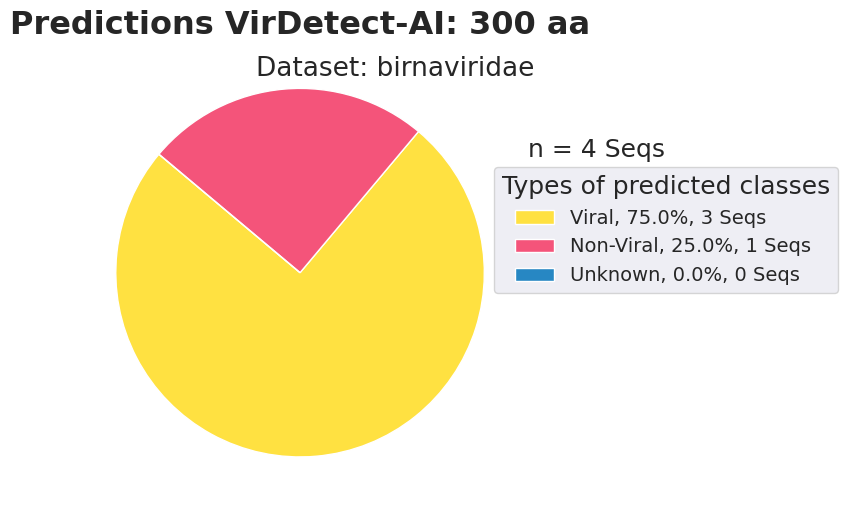

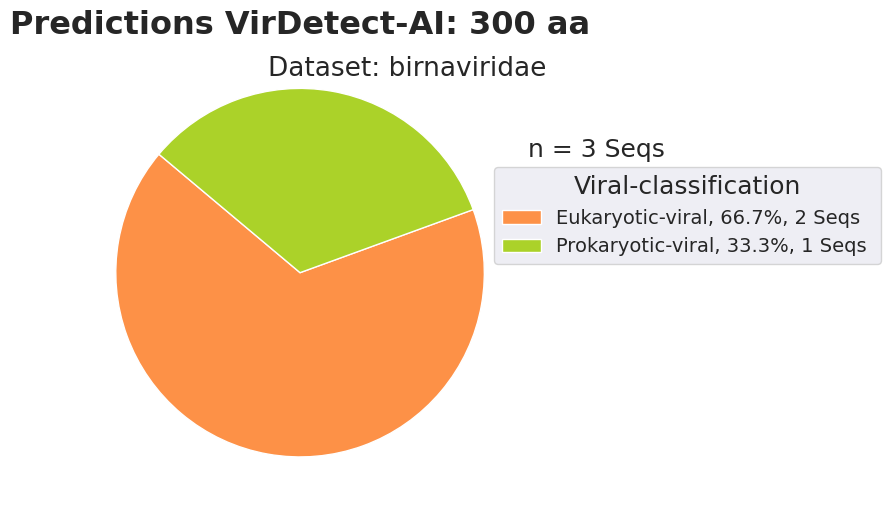

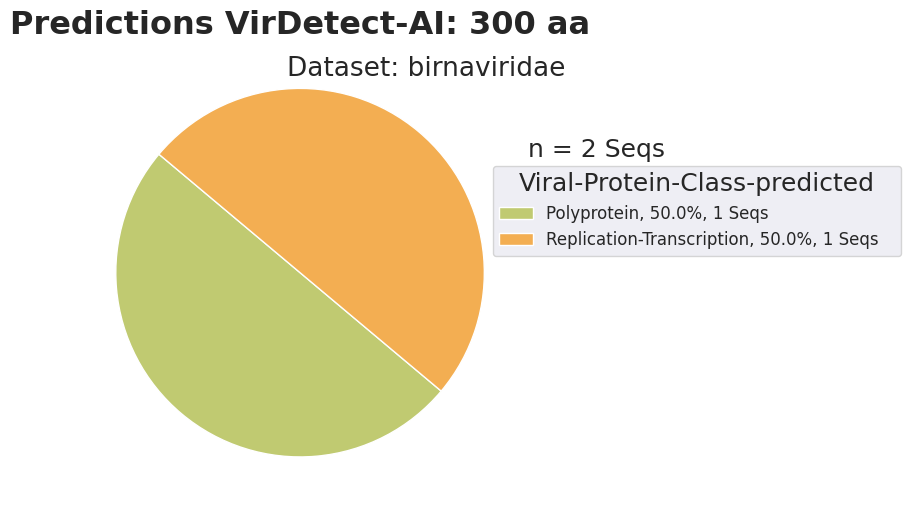

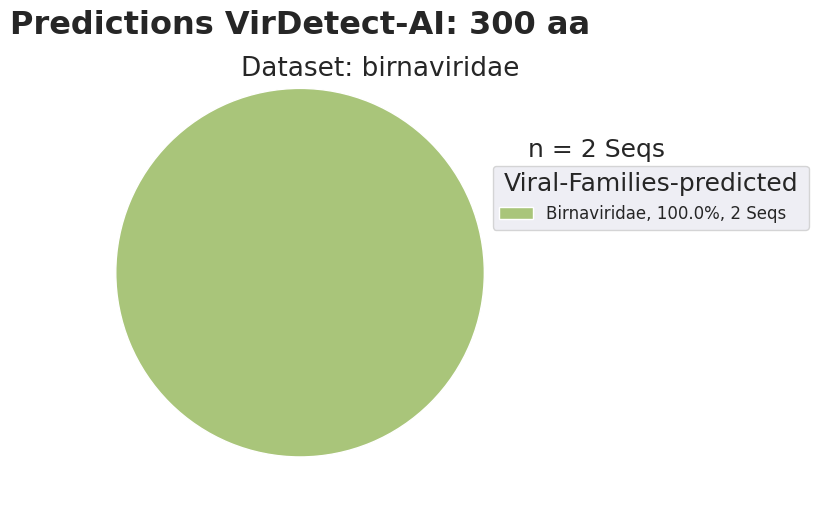

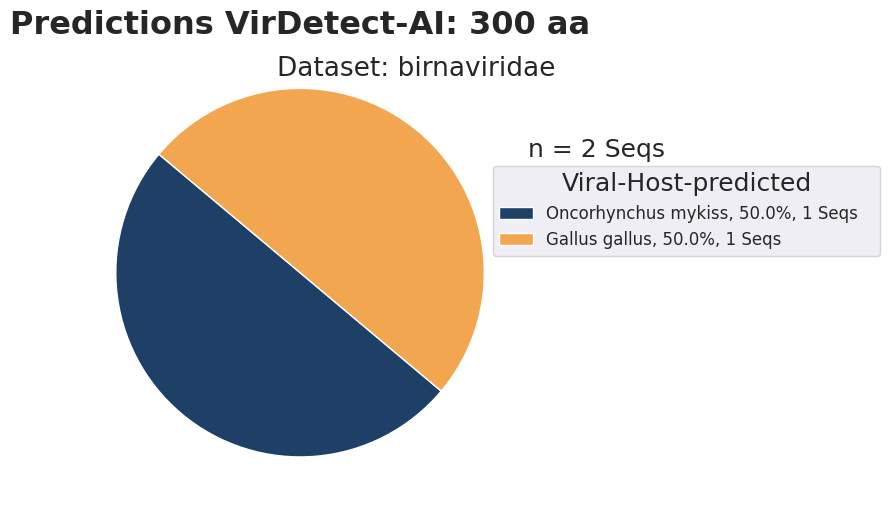

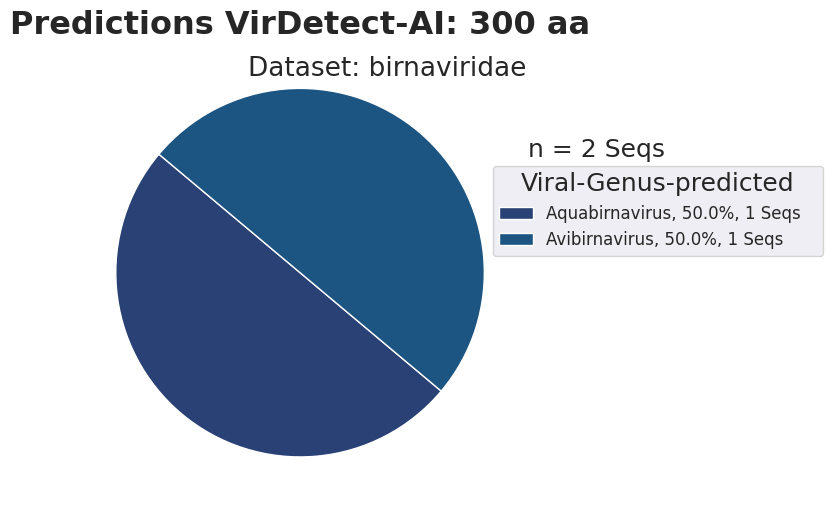

In [16]:

print(":::::::::::::: Output Report Sequences Final::::::::::::::::::::::::::::::::")
lista_seq_final=[]
lista_clase_final=[]
lista_proporcion_final=[]
lista_certeza_final=[]
lista_kmers_porcentaje=[]
lista_kmers_total_count=[]
lista_accesion_x=[]
lista_aa_x=[]

contador_pred_no=0
num_contigs_unknown=[]
acc_contigs_unknown=[]

for i in tqdm(range(len(tamanos))):
    df_tem=reporte[(reporte['Num_seq']== i)]

    num_kmers=df_tem.shape[0]

    df_tem_80=df_tem[(df_tem['Certainty']>= 0.80)] #Obtenemos solo los rows de las secuencias que queremos analizar

    if len(df_tem_80)==0:
        #print(i, "Nooo")
        contador_pred_no=contador_pred_no+1
        #print(type(name_acc_es))
        num_contigs_unknown.append(i)


    else:
        #print(i, "Siii")
        num_kmers_80=df_tem_80.shape[0]
        df_tem_80 = df_tem_80.sort_values(by='Certainty', ascending=False) #Ordenamos para evitar que se repitan probabilidades y escoja el que tenga mayor valor de certeza
        #Obtener el porcentaje de kmers que se predijeron
        #print("Seq:", i)
        #print("numero de kmers_no_corte: ",num_kmers)
        #print("numero de kmers_corte_0.80: ",num_kmers_80)

        hist_= df_tem_80['Class_predict'].value_counts() #Hacemos conteo de valores de clases que se repiten
        #print("---------------------------------------------------------------")
        #hist=df_tem_80.groupby('Class_predict').agg({'Certainty':['mean']})
        hist=df_tem_80.groupby('Class_predict').Certainty.agg({'mean'})
        hist_=hist_.to_frame()

        #En esta version de python ya pone la proporcion sin hacer todo el codigo comentado de abajo
        '''proportion=hist_['Class_predict']
        hist_['clase']=indice_
        hist_['proportion']=proportion
        hist_=hist_.drop(columns='Class_predict')'''
        hist_merge=pd.merge(hist_, hist, left_on='Class_predict', right_on='Class_predict')
        hist_merge.sort_values(by=['mean'], ascending=False)

        max_proportion=hist_merge['count'].idxmax()
        prediccion_modelo_procesada = hist_merge.loc[max_proportion]

        #Obteniendo proporcion de kmers predichos a la clase
        v=100/num_kmers
        v2=round(v*(round(prediccion_modelo_procesada['count'],2)),2)

        lista_seq_final.append(i)
        lista_clase_final.append(max_proportion)
        lista_proporcion_final.append(round(prediccion_modelo_procesada['count'],2))
        lista_certeza_final.append(round(prediccion_modelo_procesada['mean'],2))
        lista_kmers_porcentaje.append(v2)
        lista_kmers_total_count.append(num_kmers)
        lista_accesion_x.append(ids[i])
        lista_aa_x.append(tamanos[i])
        #Liberando memoria de los df
        del df_tem
        del df_tem_80
        v=0
        v2=0
        del hist
        del hist_
        del hist_merge
    time.sleep(0.1)


#--------------------------guardar  los unknown
lista_seq_unknown=[]
if len(num_contigs_unknown) > 0:
    for i in num_contigs_unknown:
        acc_contigs_unknown.append(ids[i])
        lista_seq_unknown.append(i)
if len(num_contigs_unknown) > 0:
    file_unknown=pd.DataFrame()
    file_unknown['Num_seq']=lista_seq_unknown
    file_unknown['acc_seq']=acc_contigs_unknown
    file_unknown.to_csv(path+'Report_sequences_unknown_'+tipo+'_mode_'+str(mode)+'.csv', header= True, index=False)

print(":::::::::::::: Output Report Sequences Final::::::::::::::::::::::::::::::::")
seq_predicted_percentage=round((100/len(tamanos))*len(lista_seq_final),2)
print( "from",len(tamanos),"Sequences major of ",str(kmer_long), "aa;",len(lista_seq_final), "were predicted ---->", seq_predicted_percentage, "%")

x_n=[]
x_l_rep=[]
x_l_fam_2021=[]
x_l_fam_div=[]
x_l_fam_2023=[]
x_l_clu=[]
x_l_sxc=[]
x_l_proteina=[]
x_l_proteina_class=[]
x_l_host=[]
x_l_cadena=[]
x_l_genero=[]

for i in range(len(lista_clase_final)):
    #print(i)
    clase_consultar=lista_clase_final[i]
    for x in range(len(lista_a_consultar_clase)):
        if clase_consultar==lista_a_consultar_clase[x]:
            #print(lista_a_consultar_clase[x],lista_a_consultar_rep[x],lista_a_consultar_fam[x],lista_a_consultar_clu[x],lista_a_consultar_div[x],lista_a_consultar_p[x],lista_a_consultar_sxc[x])
            x_l_rep.append(lista_a_consultar_rep[x])
            x_l_fam_2021.append(lista_a_consultar_fam_2021[x])
            x_l_fam_div.append(lista_a_consultar_fam_div[x])
            x_l_fam_2023.append(lista_a_consultar_fam_2023[x])
            x_l_clu.append(lista_a_consultar_clu[x])
            x_l_sxc.append(lista_a_consultar_sxc[x])
            x_l_proteina.append(lista_a_consultar_proteina[x])
            x_l_proteina_class.append(lista_a_consultar_protein_class[x])
            x_l_host.append(lista_a_consultar_host[x])
            x_l_cadena.append(lista_a_consultar_cadena[x])
            x_l_genero.append(lista_a_consultar_genero[x])
            x_n.append(i)


predicciones_finales=pd.DataFrame()

#predicciones_finales['num_seq']=lista_seq_final
predicciones_finales['num_seq_']=x_n
predicciones_finales['Seq_input']=lista_accesion_x
predicciones_finales['Seq_input_aa']=lista_aa_x
predicciones_finales['predicted_class']=lista_clase_final
predicciones_finales['Certainty %']=lista_certeza_final
predicciones_finales['Kmers_by_sequence']=lista_kmers_total_count
predicciones_finales['Kmers_predicted_to_class']=lista_proporcion_final
predicciones_finales['Query_coverage %']=lista_kmers_porcentaje
predicciones_finales['Rep_of_class_predict']=x_l_rep
predicciones_finales['Sequences_by_cltr']=x_l_sxc
predicciones_finales['family_2021']=x_l_fam_2021
predicciones_finales['family_2023']=x_l_fam_2023
predicciones_finales['family_divercity']=x_l_fam_div
#predicciones_finales['Cltr_rep']=x_l_clu
predicciones_finales['Genus']=x_l_genero
predicciones_finales['Protein_type']=x_l_proteina
predicciones_finales['Protein_class']=x_l_proteina_class
predicciones_finales['Host']=x_l_host
predicciones_finales['Chain']=x_l_cadena





if predicciones_finales.shape[0] == 0:
    print("Cannot create VirDetect-AI Report file because there are no sequences to report")
else:
    predicciones_finales.to_csv(path+'VirDetect-AI_'+str(kmer_long)+'-Report_'+tipo+'_'+str(fecha_)+'_mode_'+str(mode)+'.csv', header= True, index=False)



print(":::::::::::::: Output Predictions Sequences :::::::::::::::::::::::::::::::::")

cont_neg=0
cont_var=0
cont_positivo=0
for i in range(len(lista_clase_final)):
    clase_predicha_seq=lista_clase_final[i]

    if clase_predicha_seq == clase_negativa_pro:
        cont_neg=cont_neg+1
    if clase_predicha_seq == clase_negativa_variada:
        cont_var=cont_var+1
    if clase_predicha_seq != clase_negativa_pro and clase_predicha_seq != clase_negativa_variada:
        cont_positivo=cont_positivo+1

factor_seq=100/len(tamanos)

pro_neg=round(factor_seq*cont_neg,2)
pro_var=round(factor_seq*cont_var,2)
pro_positiva=round(factor_seq*cont_positivo,2)
pro_no_pred=round(factor_seq*contador_pred_no,2)
lista_conteo_types=[cont_positivo,cont_neg, cont_var,contador_pred_no]


print("Prediction sequences like Viral Euk:", pro_positiva , "%")
print("Prediction sequences like Viral Pro:", pro_neg, "%" )
print("Prediction sequences like Non Viral:", pro_var, "%")
print("Sequences No Prediction - Unknown :", pro_no_pred, "%")

#---------------------------------------------------------------------------------------------------------------
#graphs propiedades
title_model='Predictions VirDetect-AI: '+str(kmer_long)+' aa'
font_title=23
paleta_colores=["#c70039","#ed553b","#f6d55c","#3caea3","#20639b","#173f5f","#5344a9", "#7a5197","#bb5098"]
semilla = 67
random.seed(semilla)
#----------------------------------------------------------------------------------------------------------------
print(":::::::::::::: Plot Predictions Viral - Non Viral Sequences :::::::::::::::::::::::::::::::::")
viral_total=pro_positiva+pro_neg
lista_conteo_viral=[(cont_positivo+cont_neg), cont_var, contador_pred_no]
plt.figure(figsize=(9, 6))
#colors_0 = ( "#ffcb00", "#ff6150","#072448")
colors_0= ( '#FFE141', '#F4547A', '#2787C3')
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
sns.set(font_scale = 1.5)
labels_0=['Viral', 'Non-Viral', 'Unknown']
clases_0=[viral_total,pro_var, pro_no_pred]
plt.pie(clases_0,  colors=colors_0,autopct=None, startangle=140)
labels_0_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_0, clases_0, lista_conteo_viral)]
plt.legend(labels=labels_0_porcentaje, fontsize=14,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Types of predicted classes")
plt.title(title_model, fontsize=font_title, fontweight='bold')
plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
plt.text(1.61,0.60, s='n = '+str(len(tamanos))+' Seqs',   ha='center', va='bottom')
plt.tight_layout()
#plt.show()
plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Types-of-predicted-classes-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

#----------------------------------------------------------------------------------------------------------------

print(":::::::::::::: Plot Predictions Sequences :::::::::::::::::::::::::::::::::")

if (cont_positivo+ cont_neg) == 0:

    print("¡Exit Alert!")
    print("No viral sequences to analyze")
    print("The Tool VirDetect-AI has concluded its execution")
    sys.exit()  # Salir del programa
else:
    factor_viral=100/(cont_positivo+ cont_neg)
    viral_euk=round(factor_viral*cont_positivo, 2)
    viral_pro=round(factor_viral*cont_neg, 2)
    lista_conteo_virales=[cont_positivo,cont_neg ]

    plt.figure(figsize=(9.5, 6))
    #palette_color = sns.color_palette('Set2')
    #palette_color = sns.color_palette('pastel')
    #colors_1 = ( "#06d6a0", "#ff005c")
    colors_1 = ('#FD9147', '#ABD229')
    sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set(font_scale = 1.5)
    labels_1=['Eukaryotic-viral', 'Prokaryotic-viral']
    clases_1=[viral_euk, viral_pro ]
    #plt.pie([pro_positiva,pro_neg,pro_var, pro_no_pred], labels=['Eukaryotic-viral -'+str(pro_positiva)+'%', 'Prokaryotic-viral -'+str(pro_neg)+'%', 'Variety -'+str(pro_var)+'%','No Prediction-'+str(pro_no_pred)+'%'], colors=colors,autopct=None, startangle=140,)
    plt.pie(clases_1,  colors=colors_1,autopct=None, startangle=140)
    labels_1_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_1, clases_1, lista_conteo_virales)]
    plt.legend(labels=labels_1_porcentaje, fontsize=14,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-classification")
    plt.title(title_model, fontsize=font_title, fontweight='bold')
    plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
    plt.text(1.61,0.60, s='n = '+str(cont_positivo+ cont_neg)+' Seqs',   ha='center', va='bottom')
    plt.tight_layout()
    #plt.show()
    plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-classification-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

#-----------------------------------------------------------------------------------------------------------------------------------------------
#Aqui quitamos las clases que no son las euk para proceder a graficar solo la parte euk
df_predictions_final= predicciones_finales[(predicciones_finales['predicted_class']< clase_negativa_pro)]  #menor a las 2 clases negativas
#-----------------------------------------------------------------------------------------------------------------------------------------------

#validacion
if cont_positivo > 0:

    print(":::::::::::::: Plot Protein class Functions :::::::::::::::::::::::::::::::::")

    viral_class_2023=lista_a_consultar_protein_class[:-2]
    virus_class_lista = []
    for elemento in viral_class_2023:
        if elemento not in virus_class_lista:
            virus_class_lista.append(elemento)

    # Generar una paleta de colores única
    #colores_palete_class = sns.color_palette(paleta_colores, desat=0.6,  n_colors=len(virus_class_lista))
    colores_palete_class=sns.blend_palette(paleta_colores, len(virus_class_lista))
    # Crear el diccionario de colores
    #virus_class_lista_aux=sorted(virus_class_lista)
    diccionario_colores_class = dict(zip(virus_class_lista, colores_palete_class))
    nueva_clave_c = 'Others_viral_proteins'
    nuevo_valor_c = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)
    diccionario_colores_class[nueva_clave_c] = nuevo_valor_c



    #prot_class=df_predictions_final['Protein_class'].value_counts(normalize=[True,None])

    #---------------------------
    prot_class_ = pd.concat([df_predictions_final['Protein_class'].value_counts(normalize=True),df_predictions_final['Protein_class'].value_counts()], axis=1,keys=('proportion','count'))
    prot_class_ = prot_class_.sort_values(by='proportion', ascending=False)

    if prot_class_.shape[0] > 6:
        prot_class=prot_class_.head(5)
        otros= prot_class_.iloc[5:]['proportion'].sum()
        otros_counts=prot_class_.iloc[5:]['count'].sum()
        class_new_=pd.DataFrame(prot_class)
        lista=[otros]
        others_df=pd.DataFrame(index=['Others_viral_proteins'])
        others_df['proportion']=lista
        others_df['count']=otros_counts
        merge_class=pd.concat([prot_class,others_df])
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set(font_scale = 1.5)
        clases_3=merge_class['proportion']*100
        labels_3=merge_class.index
        counts_3=merge_class['count']
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.pie(clases_3,  colors=[diccionario_colores_class[label] for label in labels_3],autopct=None, startangle=140)
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Protein-Class-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Functions-Proteins-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

    else:
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
        sns.set(font_scale = 1.5)
        clases_3=prot_class_['proportion']*100
        labels_3=prot_class_.index
        counts_3=prot_class_['count']
        plt.pie(clases_3,  colors=[diccionario_colores_class[label] for label in labels_3],autopct=None, startangle=140,)
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs   ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Protein-Class-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Functions-Proteins-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

    #----------------

    print(":::::::::::::: Plot Families :::::::::::::::::::::::::::::::::")
    #colors_fam= ("#ff6150","#54d2d2","#f8aa4b","#072448","#ffcb00","#7FC15A","#45abf8","#ff8c80","#aeeaea","#fcdcb5","#1052a2","#ffe066","#B2D99C","#aab0ff","#f862bb","#dbfc24","#94f0c8")
    # Lista de keys

    viral_fam_2023=lista_a_consultar_fam_2023[:-2]

    #---------------Proceso de color
    virus_families_lista = []
    for elemento in viral_fam_2023:
        if elemento not in virus_families_lista:
            virus_families_lista.append(elemento)

    #ordenar random
    #virus_families_lista_ord = sorted(virus_families_lista, key=lambda x: random.random())
    virus_families_lista_ord = sorted(virus_families_lista,key=len)
    #print(virus_families_lista_ord)

    # Generar una paleta de colores única
    colores_palete_fam=sns.blend_palette(paleta_colores, len(virus_families_lista))

    diccionario_colores_fam = dict(zip(virus_families_lista_ord, colores_palete_fam))
    nueva_clave = 'Others_viral_families'
    nuevo_valor = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)
    diccionario_colores_fam[nueva_clave] = nuevo_valor
    #----------------Fin de proceso de color------------

    #fams_=df_predictions_final['family_2023'].value_counts(normalize=True)
    fams_ = pd.concat([df_predictions_final['family_2023'].value_counts(normalize=True),df_predictions_final['family_2023'].value_counts()], axis=1,keys=('proportion','count'))
    fams_ = fams_.sort_values(by='proportion', ascending=False)

    if fams_.shape[0] > 6:
        fams=fams_.head(5)
        otros= fams_.iloc[5:]['proportion'].sum()
        otros_counts=fams_.iloc[5:]['count'].sum()
        fams_new_=pd.DataFrame(fams)
        lista=[otros]
        others_df=pd.DataFrame(index=['Others_viral_families'])
        others_df['proportion']=lista
        others_df['count']=otros_counts
        merge_families=pd.concat([fams,others_df])
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set(font_scale = 1.5)
        clases_3=merge_families['proportion']*100
        labels_3=merge_families.index
        counts_3=merge_families['count']


        #plt.pie(clases_3,  colors=list(diccionario_colores_fam.values()),autopct=None, startangle=140)
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.pie(clases_3,  colors=[diccionario_colores_fam[label] for label in labels_3],autopct=None, startangle=140)
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Families-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Families-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)



    else:
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
        sns.set(font_scale = 1.5)
        clases_3=fams_['proportion']*100
        labels_3=fams_.index
        counts_3=fams_['count']
        plt.pie(clases_3,  colors=[diccionario_colores_fam[label] for label in labels_3],autopct=None, startangle=140,)
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs   ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Families-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Families-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

    #--------------------------------------------------------------------------

    print(":::::::::::::: Plot Host :::::::::::::::::::::::::::::::::")
    #Get color
    viral_host_c=lista_a_consultar_host[:-2]

    virus_host_lista = []
    for elemento in viral_host_c:
        if elemento not in virus_host_lista:
            virus_host_lista.append(elemento)



    #colores_palete_host = sns.color_palette(paleta_colores, desat=0.6,n_colors=len(virus_host_lista))
    colores_palete_host=sns.blend_palette(paleta_colores, len(virus_host_lista))

    #ordenar random
    virus_host_lista_ord = sorted(virus_host_lista,key=len)

    diccionario_colores_host = dict(zip(virus_host_lista_ord, colores_palete_host))
    nueva_clave_h = 'Others_viral_hosts'
    nuevo_valor_h = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)
    diccionario_colores_host[nueva_clave_h] = nuevo_valor_h
    #Color end

    host_=pd.concat([df_predictions_final['Host'].value_counts(normalize=True),df_predictions_final['Host'].value_counts()], axis=1,keys=('proportion','count'))
    host_ = host_.sort_values(by='proportion', ascending=False)

    if host_.shape[0] > 6:
        host=host_.head(5)
        otros=host_.iloc[5:]['proportion'].sum()
        otros_counts=host_.iloc[5:]['count'].sum()
        host_new_=pd.DataFrame(host)
        lista=[otros]
        others_df=pd.DataFrame(index=['Others_viral_hosts'])
        others_df['proportion']=lista
        others_df['count']=otros_counts
        merge_host=pd.concat([host,others_df])
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set(font_scale = 1.5)
        clases_3=merge_host['proportion']*100
        labels_3=merge_host.index
        counts_3=merge_host['count']

        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.pie(clases_3,  colors=[diccionario_colores_host[label] for label in labels_3],autopct=None, startangle=140)
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Host-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Host-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

    else:
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
        sns.set(font_scale = 1.5)
        clases_3=host_['proportion']*100
        labels_3=host_.index
        counts_3=host_['count']
        plt.pie(clases_3,  colors=[diccionario_colores_host[label] for label in labels_3],autopct=None, startangle=140,)
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs   ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Host-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Host-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)



    print(":::::::::::::: Plot Genus :::::::::::::::::::::::::::::::::")

    viral_genus_2023=lista_a_consultar_genero[:-2]

    virus_genus_lista = []
    for elemento in viral_genus_2023:
        if elemento not in virus_genus_lista:
            virus_genus_lista.append(elemento)
    # Generar una paleta de colores única
    #colores_palete_genus = sns.color_palette(paleta_colores, desat=0.6,n_colors=len(virus_genus_lista))
    colores_palete_genus=sns.blend_palette(paleta_colores, len(virus_genus_lista))

    #ordenar random
    virus_genus_lista_ord = sorted(virus_genus_lista, key=len)
    # Crear el diccionario de colores
    diccionario_colores_genus = dict(zip(virus_genus_lista_ord, colores_palete_genus))
    nueva_clave_g = 'Others_viral_genus'
    nuevo_valor_g = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)
    diccionario_colores_genus[nueva_clave_g] = nuevo_valor_g

    genus_=pd.concat([df_predictions_final['Genus'].value_counts(normalize=True),df_predictions_final['Genus'].value_counts()], axis=1,keys=('proportion','count'))
    genus_ = genus_.sort_values(by='proportion', ascending=False)

    if genus_.shape[0] > 6:
        genus=genus_.head(5)
        otros= genus_.iloc[5:]['proportion'].sum()
        otros_counts=genus_.iloc[5:]['count'].sum()
        genus_new_=pd.DataFrame(genus)
        lista=[otros]
        others_df=pd.DataFrame(index=['Others_viral_genus'])
        others_df['proportion']=lista
        others_df['count']=otros_counts
        merge_genus=pd.concat([genus,others_df])
        plt.figure(figsize=(9, 6))
        sns.set(font_scale = 1.5)
        clases_3=merge_genus['proportion']*100
        labels_3=merge_genus.index
        counts_3=merge_genus['count']
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.pie(clases_3,  colors=[diccionario_colores_genus[label] for label in labels_3],autopct=None, startangle=140)
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Genus-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Genus-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)

    else:
        plt.figure(figsize=(9, 6))
        #palette_color = sns.color_palette('Set2')
        sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
        sns.set(font_scale = 1.5)
        clases_3=genus_['proportion']*100
        labels_3=genus_.index
        counts_3=genus_['count']
        plt.pie(clases_3,  colors=[diccionario_colores_genus[label] for label in labels_3],autopct=None, startangle=140,)
        labels_3_porcentaje=[f'{l}, {s:0.1f}%, {w} Seqs   ' for l, s, w in zip(labels_3, clases_3, counts_3)]
        plt.legend(labels=labels_3_porcentaje, fontsize=12,loc='upper left', bbox_to_anchor=(0.9, 0.75),title="Viral-Genus-predicted")
        plt.title(title_model,fontsize=font_title, fontweight='bold')
        plt.suptitle('Dataset: '+str(tipo), y=0.79, fontsize=19)
        plt.text(1.61,0.60, s='n = '+str(cont_positivo)+' Seqs',   ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(path+'VirDetect-AI_'+str(kmer_long)+'-Viral-Genus-predicted-'+str(tipo)+'_'+str(fecha_)+'_mode_'+str(mode)+'.png',dpi=300)
else:
    print("¡Exit Alert!")
    print("No eukaryiotic viral sequences to analyze")
    print("The Tool VirDetect-AI has concluded its execution")
    sys.exit()  # Salir del programa

print("The Tool VirDetect-AI has concluded its execution")